In [1]:
from header import *
from util import *
import types
from lmfit.models import SkewedGaussianModel

In [2]:
foggie_dir = '/Users/acharyya/models/simulation_output/foggie/' #'/Volumes/Elements/foggieforayan/' # 
halo = '8508'
run = 'nref11c_nref9f'
output = 'DD2427'
ds = yt.load(foggie_dir + 'halo_00' + halo + '/' + run + '/' + output + '/' + output)

yt : [INFO     ] 2022-08-17 16:35:22,001 Parameters: current_time              = 639.44480357087
yt : [INFO     ] 2022-08-17 16:35:22,002 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2022-08-17 16:35:22,003 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-08-17 16:35:22,004 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-08-17 16:35:22,004 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-08-17 16:35:22,005 Parameters: current_redshift          = 0
yt : [INFO     ] 2022-08-17 16:35:22,006 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2022-08-17 16:35:22,006 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2022-08-17 16:35:22,007 Parameters: omega_radiation           = 0
yt : [INFO     ] 2022-08-17 16:35:22,007 Parameters: hubble_constant           = 0.695


In [3]:
galrad = 10 # kpc
galrad = galrad / (1 + ds.current_redshift) / 0.695 # to convert to comoving galrad ckpch^-1 as sopposed to physical galrad kpc
box_width = 2 * galrad # kpc
res = 0.1 # kpc
nbins = 100
xmax = 4
field = ('gas', 'metallicity')
print(galrad)

14.388489208633095


In [4]:
args = types.SimpleNamespace()
args.code_path = '/Users/acharyya/Work/astro/ayan_codes/foggie/foggie/'
args.halo = halo
args.run = run
args.output = output
args.system = 'ayan_hd'
args.silent, args.print_to_file, args.pwd = False, False, False
args = pull_halo_center(args)
print(args.halo_center)

[0] {MacBook-Pro.local} Pulling halo center from catalog file

[70482.02075546594 67798.01073691827 73316.14871676877]


In [5]:
box_center = ds.arr(args.halo_center, kpc)
box_width_kpc = ds.arr(box_width, 'kpc')
box = ds.r[box_center[0] - box_width_kpc / 2.: box_center[0] + box_width_kpc / 2., box_center[1] - box_width_kpc / 2.: box_center[1] + box_width_kpc / 2., box_center[2] - box_width_kpc / 2.: box_center[2] + box_width_kpc / 2., ]
print(box_center, box_width)

Parsing Hierarchy : 100%|██████████| 4262/4262 [00:00<00:00, 7948.67it/s]
yt : [INFO     ] 2022-08-17 16:35:22,723 Gathering a field list (this may take a moment.)


[70482.02075546594 67798.01073691827 73316.14871676877] kpc 28.77697841726619


In [6]:
Znative = box[field].in_units('Msun').ndarray_view()
dnative = box[('gas', 'density')].in_units('Msun/pc**3').ndarray_view()
mnative = box[('gas', 'mass')].in_units('Msun').ndarray_view()

Up to this ^ was 2D FRBs..the following is for 3D FRBs

In [44]:
ax = 1 # 0 Or 1 Or 2
ncells = int(box_width/res)
print(ncells)
#box = ds.r[box_center[0] - box_width_kpc / 2.: box_center[0] + box_width_kpc / 2.:str(ncells)+'j', box_center[1] - box_width_kpc / 2.: box_center[1] + box_width_kpc / 2.:str(ncells)+'j', box_center[2] - box_width_kpc / 2.: box_center[2] + box_width_kpc / 2.:str(ncells)+'j']
box = ds.arbitrary_grid(left_edge=[box_center[0] - box_width_kpc / 2., box_center[1] - box_width_kpc / 2., box_center[2] - box_width_kpc / 2.], \
                        right_edge=[box_center[0] + box_width_kpc / 2., box_center[1] + box_width_kpc / 2., box_center[2] + box_width_kpc / 2.], \
                        dims=[ncells, ncells, ncells])


287


In [45]:
ds.all_data()[('gas', 'mass')].sum(), box_width_kpc, np.shape(box), box[('gas', 'mass')].sum()

(unyt_quantity(3.66074507e+49, 'g'),
 unyt_array(28.77697842, 'kpc'),
 (287, 287, 287),
 unyt_quantity(2.90218733e+43, 'g'))

In [46]:
mass_res = box['mass'].in_units('Msun').ndarray_view()
#plt.imshow(np.log10(mass_res.sum(axis=ax)), cmap='viridis')
#plt.colorbar()

In [47]:
metal_res = box['metal_mass'].in_units('Msun').ndarray_view()
#plt.imshow(np.log10(metal_res.sum(axis=ax)), cmap='viridis')
#plt.colorbar()

In [48]:
Zres_direct = box['metallicity'].in_units('Zsun').ndarray_view()
#plt.imshow(Zres_direct.mean(axis=ax), cmap='viridis')
#plt.colorbar()
len(Zres_direct), np.shape(Zres_direct),np.median(Zres_direct)

(287, (287, 287, 287), 0.2433946011000824)

(287, (287, 287), 0.30193708216403226)

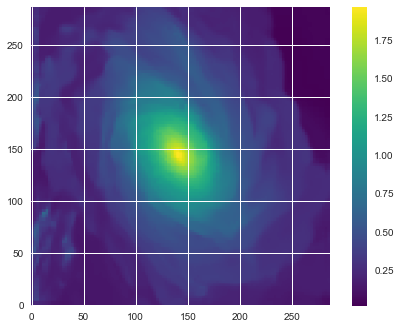

In [49]:
from yt.utilities.physical_ratios import metallicity_sun
Zres_div = metal_res.sum(axis=ax) / mass_res.sum(axis=ax) / metallicity_sun
plt.imshow(Zres_div, cmap='viridis')
plt.colorbar()
len(Zres_div), np.shape(Zres_div),  np.median(Zres_div)

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 709
    # data points      = 100
    # variables        = 4
    chi-square         = 0.75092658
    reduced chi-square = 0.00782215
    Akaike info crit   = -481.161758
    Bayesian info crit = -470.741077
[[Variables]]
    amplitude:  1.01532672 +/- 0.12000169 (11.82%) (init = 0.5)
    center:     0.14002353 +/- 0.09359959 (66.85%) (init = 0.5)
    sigma:      0.68780721 +/- 0.05525174 (8.03%) (init = 0.5)
    gamma:      23681.4973 +/- 91731614.1 (387355.63%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, gamma)     = -1.000
    C(amplitude, gamma)  =  0.980
    C(amplitude, center) = -0.980
    C(amplitude, sigma)  =  0.959
    C(sigma, gamma)      =  0.940
    C(center, sigma)     = -0.940


Text(0.95, 0.75, 'DD2427')

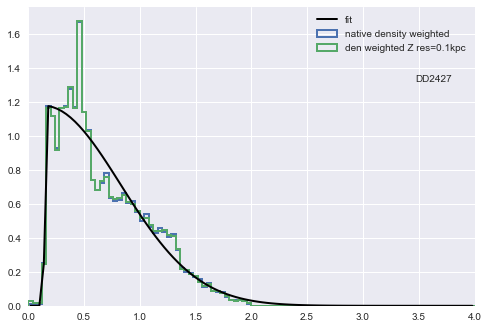

In [52]:
model = SkewedGaussianModel()
params = model.make_params(amplitude=0.5, center=0.5, sigma=0.5, gamma=0)

y, x = np.histogram(Zres_direct.flatten(), bins=nbins, density=True, weights=mass_res.flatten(), range=(0, xmax))
x = x[:-1] + np.diff(x)/2
result = model.fit(y, params, x=x)
print(result.fit_report())

plt.hist(Znative, bins=nbins, range=(0, xmax), histtype='step', lw=2, density=True, weights=dnative, label='native density weighted')
plt.hist(Zres_direct.flatten(), bins=nbins, range=(0, xmax), histtype='step', lw=2, density=True, weights=mass_res.flatten(), label='den weighted Z res=%.1Fkpc'%(res))
plt.plot(x, result.best_fit, c='k', lw=2, label='fit')
plt.legend()
plt.xlim(0, xmax)
ax=plt.gca()
plt.text(0.95, 0.75, args.output, ha='right', transform=ax.transAxes)

In [14]:
def skewed_gauss(x, p):
    #print('p shape in skewed_gauss', np.shape(p)) #
    y = gauss(x, p[:3]) * (1 + erf((p[3] * x)/np.sqrt(2)))
    return y

# ----------------------------------------------------------------
def gauss(x, p):
    #print('p shape in gauss', np.shape(p)) #
    y = p[0] * exp(-((x - p[1]) ** 2) / (2 * p[2] ** 2))
    return y

# ----------------------------------------------------------------
def multiple_gauss(x, *p):
    #print('p shape in multiple_gauss', np.shape(p)) #
    #print('p[:3] shape in multiple_gauss', np.shape(p[:3])) #
    y = gauss(x, p[:3]) + skewed_gauss(x, p[3:])
    return y

(7,) [0.7858298  0.37885774 0.1        0.36280986 0.63302365 0.51618653
 8.46806061]


Text(0.95, 0.5, 'DD2427')

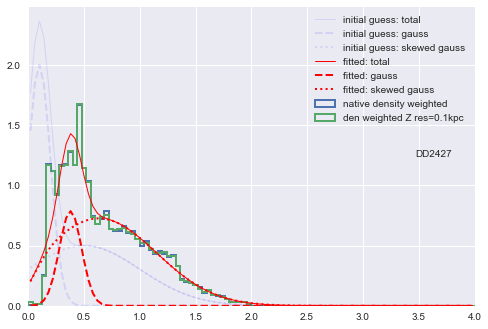

In [25]:
p0 = [2, 0.1, 0.1, 0.5, 0.5, 0.5, 0] # initial guess for parameters; [gaussian amplitude, gaussian mean, gaussian sigma, skewed gaussian amplitude, skewed gaussian mean, skewed gaussian sigma, skewed gaussian gamma]
lower_bounds = np.zeros(len(p0))
upper_bounds = [np.inf, 0.4, 0.1, np.inf, np.inf, np.inf, np.inf]
result, cov = curve_fit(multiple_gauss, x, y, p0=p0, bounds=[lower_bounds, upper_bounds], maxfev=int(1e4))
print(np.shape(result), result)

plt.hist(Znative, bins=nbins, range=(0, xmax), histtype='step', lw=2, density=True, weights=dnative, label='native density weighted')
plt.hist(Zres_direct.flatten(), bins=nbins, range=(0, xmax), histtype='step', lw=2, density=True, weights=mass_res.flatten(), label='den weighted Z res=%.1Fkpc'%(res))

plt.plot(x, multiple_gauss(x, *p0), c='b', lw=1, alpha=0.1, label='initial guess: total')
plt.plot(x, gauss(x, p0[:3]), c='b', lw=2, ls='--', alpha=0.1, label='initial guess: gauss')
plt.plot(x, skewed_gauss(x, p0[3:]), c='b', lw=2, ls='dotted', alpha=0.1, label='initial guess: skewed gauss')

plt.plot(x, multiple_gauss(x, *result), c='r', lw=1, label='fitted: total')
plt.plot(x, gauss(x, result[:3]), c='r', lw=2, ls='--', label='fitted: gauss')
plt.plot(x, skewed_gauss(x, result[3:]), c='r', lw=2, ls='dotted', label='fitted: skewed gauss')

plt.legend()
plt.xlim(0, xmax)
ax=plt.gca()
plt.text(0.95, 0.5, args.output, ha='right', transform=ax.transAxes)

In [51]:
Ztotal1 = np.sum(Zres_direct) / np.sum(mass_res) / metallicity_sun
Ztotal2 = np.sum(metal_res) / np.sum(mass_res) / metallicity_sun
Ztotal25 = np.sum(Zres_direct * mass_res) / np.sum(mass_res)
Ztotal3 = np.sum(Znative * mnative * metallicity_sun) / np.sum(mnative) / metallicity_sun
Ztotal4 = np.sum(Znative * mnative) / np.sum(mnative)
print(Ztotal1, Ztotal2, Ztotal25, Ztotal3, Ztotal4)

0.09732934434627316 0.6855234563928411 0.6855234563928427 0.6850879790156381 0.6850879790156381
